# Tarefa 02
Nesta tarefa vocês irão projetar duas arquiteturas de CNN utilizando os conceitos, camadas e técnicas vistas no curso. As redes serão treinadas no dataset CIFAR-10 e depois comparadas. As tarefas são:

**1) Definir as arquiteturas; ----> 0.3 pontos** 

- Quantas [camadas](https://keras.io/layers/core/) ela terá?
- Quais as operações utilizadas (convoluções, pooling, fully-connected)?
- Quais serão os parâmetros de cada camada (número e tamanho dos filtros convolucionais, stride, tamanho do pooling, funções de ativação)?
- Que tipo de [inicialização](https://keras.io/initializers/) de pesos você utilizará?
- Haverá dropout? Qual a taxa de dropout? 
- Haverá [regularização](https://keras.io/regularizers/)? Qual a taxa do regularizador?

**2) Definir como será o treino; ----> 0.25 pontos**
- Número de épocas e tamanho do batch (deixe igual p/ as duas redes);
- [Otimizador](https://keras.io/optimizers/);
- [Função de custo](https://keras.io/losses/);

**3) Classificar o conjunto de teste e comparar os resultados; ----> 0.25 pontos**
- Classificar imagens de teste;
- Comparar acurácias;
- Plotar loss pelo número de épocas no conjunto de treinamento e validação de cada rede. 
    
**4) Escrever um parágrafo com as suas conclusões; ----> 0.2 pontos**

-----

## CIFAR-10
Este conjunto de dados é composto de 60000 imagens coloridas de dimensões 32x32, divididas em 10 classes (com 6000 imagens por classe), sendo 50000 para treinamento e 10000 para teste. As classes do CIFAR-10 são **aviões, automóveis, pássaros, gatos, alces, cachorros, sapos, cavalos, navios, caminhões.**

O código abaixo carrega e transforma os dados de entrada para ficarem prontos para serem treinados/classificados pela sua rede. Os conjuntos de treino, validação e teste estão balanceados, portanto a acurácia já estará normalizada nos métodos do Keras.  

In [79]:
#Imports
import os
import numpy as np
from random import seed
seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

from keras.datasets import cifar10
from keras.utils import np_utils
#from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit


#Load data
(trainVal_data, trainVal_label), (X_test, y_test) = cifar10.load_data()

# Caso alguem tenha problemas com o StratifiedShuffleSplit, tente descomentar essa versao
#Split trainVal data into train and val sets (already balanced)
# splitIdx = StratifiedShuffleSplit(trainVal_label, 1, test_size=10000, random_state=0)
# for train_index, val_index in splitIdx:
#     X_train, X_val = trainVal_data[train_index], trainVal_data[val_index]
#     y_train, y_val = trainVal_label[train_index], trainVal_label[val_index]
    

splitIdx = StratifiedShuffleSplit(1, test_size=10000, random_state=0)
for train_index, val_index in splitIdx.split(trainVal_data, trainVal_label):
    X_train, X_val = trainVal_data[train_index], trainVal_data[val_index]
    y_train, y_val = trainVal_label[train_index], trainVal_label[val_index]

    
#Transform data
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_val /= 255
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Validation matrix shape", X_val.shape)
print("Testing matrix shape", X_test.shape)

Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)

Training matrix shape (40000, 32, 32, 3)
Validation matrix shape (10000, 32, 32, 3)
Testing matrix shape (10000, 32, 32, 3)


--------
--------
--------
**A tarefa de vocês começa aqui!!!**

# Definir as duas arquiteturas - [0.3 pontos]
***Não se esqueçam de***:
    - Importar as camadas utilizadas e o tipo do modelo (Sequential);
    - Passar o input_shape na primeira camada da rede;
    - Utilizar ativação `softmax` na última camada densa da rede;

In [80]:
#Imports
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers # other stuff needed ... 
from keras.optimizers import Adam

In [83]:
# Define 1st architecture
modelOne = Sequential()
classes = 10
modelOne.add(Conv2D(20, kernel_size=(5,5), activation='relu', input_shape=(32,32,3)))
modelOne.add(MaxPooling2D(pool_size=(2,2)))
modelOne.add(Flatten())
modelOne.add(Dropout(0.25))
modelOne.add(Dense(classes, activation='softmax',kernel_initializer='glorot_uniform', kernel_regularizer=None))


In [84]:
# Define 2nd architecture
modelTwo = Sequential()
modelTwo.add(Conv2D(20, kernel_size=(2, 5),activation='sigmoid',input_shape=(32,32,3)))
modelTwo.add(MaxPooling2D(pool_size=(2, 2)))
modelTwo.add(Flatten())
modelTwo.add(Dense(10, activation='softmax', kernel_initializer='random_normal', kernel_regularizer=regularizers.l2(0.01)))


NameError: name 'regularizers' is not defined

# Treinamento - [0.25 pontos]
***Não se esqueçam de***:
    - Escolher otimizador e loss;
    - Compilar o modelo;
    - Definir número de épocas, tamanho do batch (utilizar o mesmo para ambas as redes);
    - Passar o conjunto de validação em `validation_data`;

In [70]:
historyList = []

#Compile first model
#sgd = optimizers.SGD(lr=0.01) #lr = learning rate
modelOne.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

#Train first CNN
historyList.append(modelOne.fit(X_train, Y_train,
          batch_size=128, epochs=10, verbose=0,
          validation_data=(X_val, Y_val)))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 33s 836us/step - loss: 2.1470 - acc: 0.2086 - val_loss: 1.9689 - val_acc: 0.3113
Epoch 2/10
40000/40000 [==============================] - 38s 945us/step - loss: 1.9244 - acc: 0.3143 - val_loss: 1.8393 - val_acc: 0.3635
Epoch 3/10
40000/40000 [==============================] - 39s 968us/step - loss: 1.8104 - acc: 0.3613 - val_loss: 1.7415 - val_acc: 0.3925
Epoch 4/10
40000/40000 [==============================] - 39s 982us/step - loss: 1.7234 - acc: 0.3932 - val_loss: 1.6790 - val_acc: 0.4121
Epoch 5/10
40000/40000 [==============================] - 39s 971us/step - loss: 1.6619 - acc: 0.4156 - val_loss: 1.6155 - val_acc: 0.4383
Epoch 6/10
40000/40000 [==============================] - 38s 952us/step - loss: 1.6125 - acc: 0.4304 - val_loss: 1.5688 - val_acc: 0.4548
Epoch 7/10
40000/40000 [==============================] - 39s 984us/step - loss: 1.5719 - acc: 0.4462 - val_loss: 1.

In [71]:
#Compile second model
modelTwo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train second CNN
historyList.append(modelTwo.fit(X_train, Y_train, 
             batch_size=128, epochs=10,verbose=0,
             validation_data=(X_val, Y_val)))

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 25s 615us/step - loss: 2.3023 - acc: 0.1312 - val_loss: 2.2681 - val_acc: 0.1378
Epoch 2/10
40000/40000 [==============================] - 24s 610us/step - loss: 2.1825 - acc: 0.1923 - val_loss: 2.1705 - val_acc: 0.2285
Epoch 3/10
40000/40000 [==============================] - 25s 617us/step - loss: 2.1048 - acc: 0.2318 - val_loss: 2.1651 - val_acc: 0.2106
Epoch 4/10
40000/40000 [==============================] - 23s 580us/step - loss: 2.0526 - acc: 0.2572 - val_loss: 2.0609 - val_acc: 0.2325
Epoch 5/10
40000/40000 [==============================] - 24s 596us/step - loss: 2.0090 - acc: 0.2772 - val_loss: 2.0690 - val_acc: 0.2453
Epoch 6/10
40000/40000 [==============================] - 25s 634us/step - loss: 1.9760 - acc: 0.2919 - val_loss: 1.9758 - val_acc: 0.2956
Epoch 7/10
40000/40000 [==============================] - 26s 644us/step - loss: 1.9504 - acc: 0.3027 - val_loss: 1.

# Resultados no conjunto de teste [0.25 pontos]
***Não se esqueçam de***:
    - Classificar as imagens do conjunto de teste utilizando cada rede;
    - Computar acurácia para cada rede;
    - Comparar ambas as acurácias;
    - Plotar loss pelo número de épocas no conjunto de treinamento e validação de cada rede. 

In [72]:
# Classify test set
score = modelOne.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT NORMALIZED):', score[1])

score = modelTwo.evaluate(X_test, Y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy (NOT NORMALIZED):', score[1])

10000/10000 [==============================] - 4s 448us/step
Test loss: 1.432932286453247
Test accuracy (NOT NORMALIZED): 0.4982
10000/10000 [==============================] - 3s 259us/step
Test loss: 1.8929760646820069
Test accuracy (NOT NORMALIZED): 0.3289


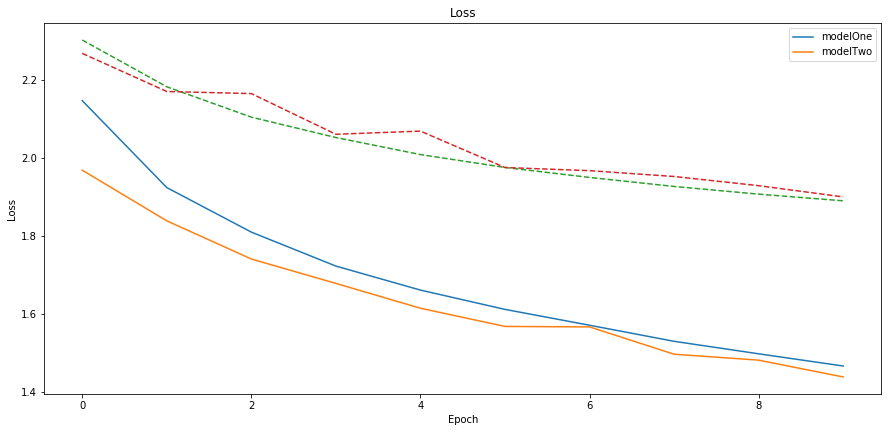

In [78]:
def plot_loss_accuracy(history, legend, plotSet="both"):
    linestyles = ['-', '--']

    #Plot Loss
    plt.subplot(2, 1, 1)

    for idx,hist in enumerate(historyList):
        if plotSet in ["train", "both"]:
            plt.plot(hist.history['loss'], linestyle=linestyles[idx%len(linestyles)])
        if 'val_loss' in hist.history.keys() and plotSet in ["test", "both"]:
            plt.plot(hist.history['val_loss'], linestyle=linestyles[idx%len(linestyles)])

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title("Loss")    
    plt.legend(legend, loc='best')    

    plt.show()
    
legend = ["modelOne", "modelTwo"]
plot_loss_accuracy(historyList, legend)

# Conclusões [0.2 pontos]
Escrevam um parágrafo com as conclusões que vocês tiraram na tarefa. Comentem as diferenças entre as duas arquiteturas e em seus treinamentos, apontando a motivação pelas decisões tomadas. Se o resultado ficou melhor/pior do que o que você esperava, o que você acha que pode ter acontecido?

In [10]:
# Write your paragraph here!